# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/younesbelkada/transformers.git (to revision blip-train-support) to /tmp/pip-req-build-gn4s6x3z
  Running command git clone --filter=blob:none --quiet https://github.com/younesbelkada/transformers.git /tmp/pip-req-build-gn4s6x3z
  Running command git checkout -b blip-train-support --track origin/blip-train-support
  Switched to a new branch 'blip-train-support'
  Branch 'blip-train-support' set up to track remote branch 'blip-train-support' from 'origin'.
  Resolved https://github.com/younesbelkada/transformers.git to commit 27c6b9889d900fb87dfdec225b0d8e7c4fa09937
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
from transformers import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")

Let's retrieve the caption of the first example:

In [ ]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

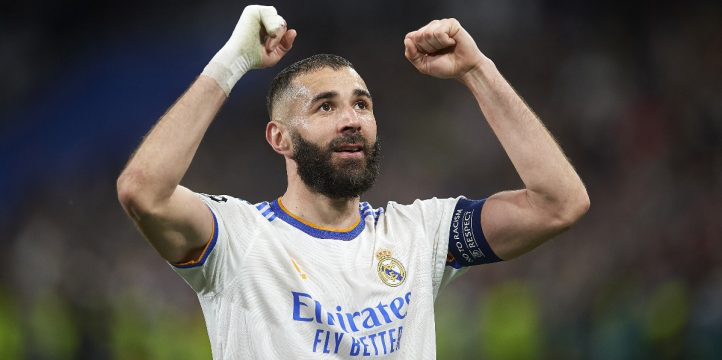

In [ ]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 13.106168746948242
Loss: 10.644421577453613
Loss: 9.593768119812012
Epoch: 1
Loss: 9.306917190551758
Loss: 9.081585884094238
Loss: 8.899713516235352
Epoch: 2
Loss: 8.757176399230957
Loss: 8.57335090637207
Loss: 8.46764087677002
Epoch: 3
Loss: 8.328741073608398
Loss: 8.201028823852539
Loss: 8.095505714416504
Epoch: 4
Loss: 7.967352867126465
Loss: 7.861735820770264
Loss: 7.732804298400879
Epoch: 5
Loss: 7.630571365356445
Loss: 7.519181251525879
Loss: 7.405021667480469
Epoch: 6
Loss: 7.284258842468262
Loss: 7.187586784362793
Loss: 7.060364723205566
Epoch: 7
Loss: 6.954672813415527
Loss: 6.846510410308838
Loss: 6.6976189613342285
Epoch: 8
Loss: 6.587822437286377
Loss: 6.486807346343994
Loss: 6.362427711486816
Epoch: 9
Loss: 6.233264923095703
Loss: 6.120891571044922
Loss: 5.994716644287109
Epoch: 10
Loss: 5.855278968811035
Loss: 5.752918243408203
Loss: 5.645371437072754
Epoch: 11
Loss: 5.505440711975098
Loss: 5.391564846038818
Loss: 5.268132209777832
Epoch: 12
Loss: 5.1524944

## Inference

Let's check the results on our train dataset

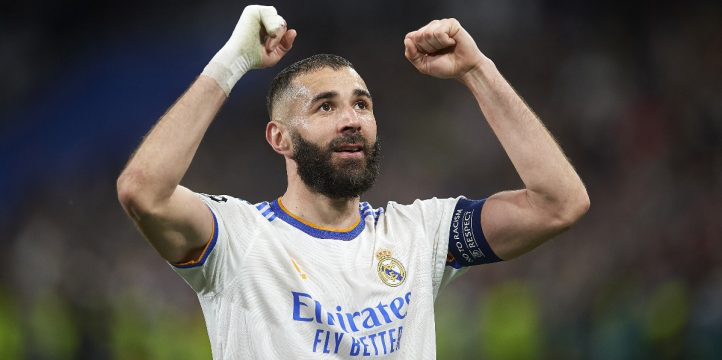

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid's win against psg


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

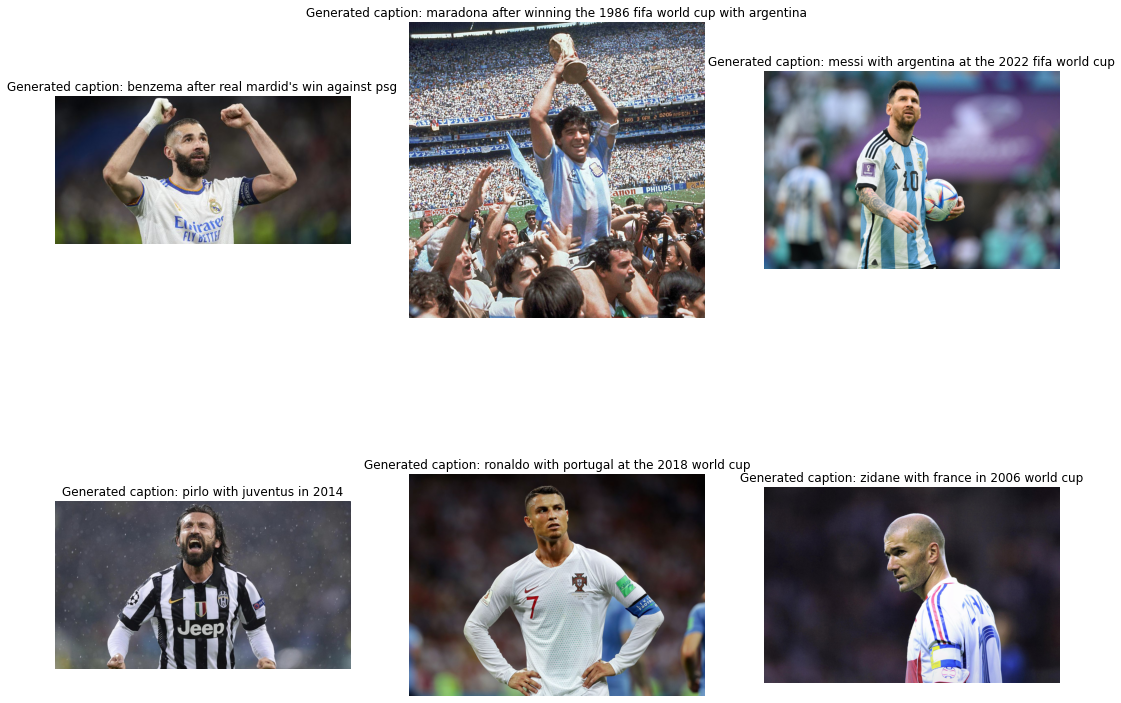

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")